# Model Creation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sqlalchemy import create_engine
import sqlite3
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.model_selection import RandomizedSearchCV

In [2]:
con = sqlite3.connect("../database/PreprocessData.db")
data = pd.read_sql_query("SELECT * FROM houseData", con)

In [3]:
data

,Price,Area,Location,Resale,MaintenanceStaff,State
0,3400000,1050,Nala Sopara,1,9,Mumbai
1,6500000,1550,Central Excise Colony Hyderabad,1,0,Hyderabad
2,7700000,1405,Rajarhat,1,9,Kolkata
3,8075000,975,Baguiati,1,9,Kolkata
4,2725000,639,Avadi,0,0,Chennai
...,...,...,...,...,...,...
16477,3500000,990,Bharat Vihar,0,9,Delhi
16478,5599000,1018,Sholinganallur,0,0,Chennai
16479,2758000,1138,Maniktala,0,9,Kolkata
16480,9900000,1300,Thane West,0,9,Mumbai


C:\Users\debor\AppData\Local\Temp\ipykernel_20052\2679073343.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Price'].sort_values(ascending=True).plot(kind="bar")


<AxesSubplot: >

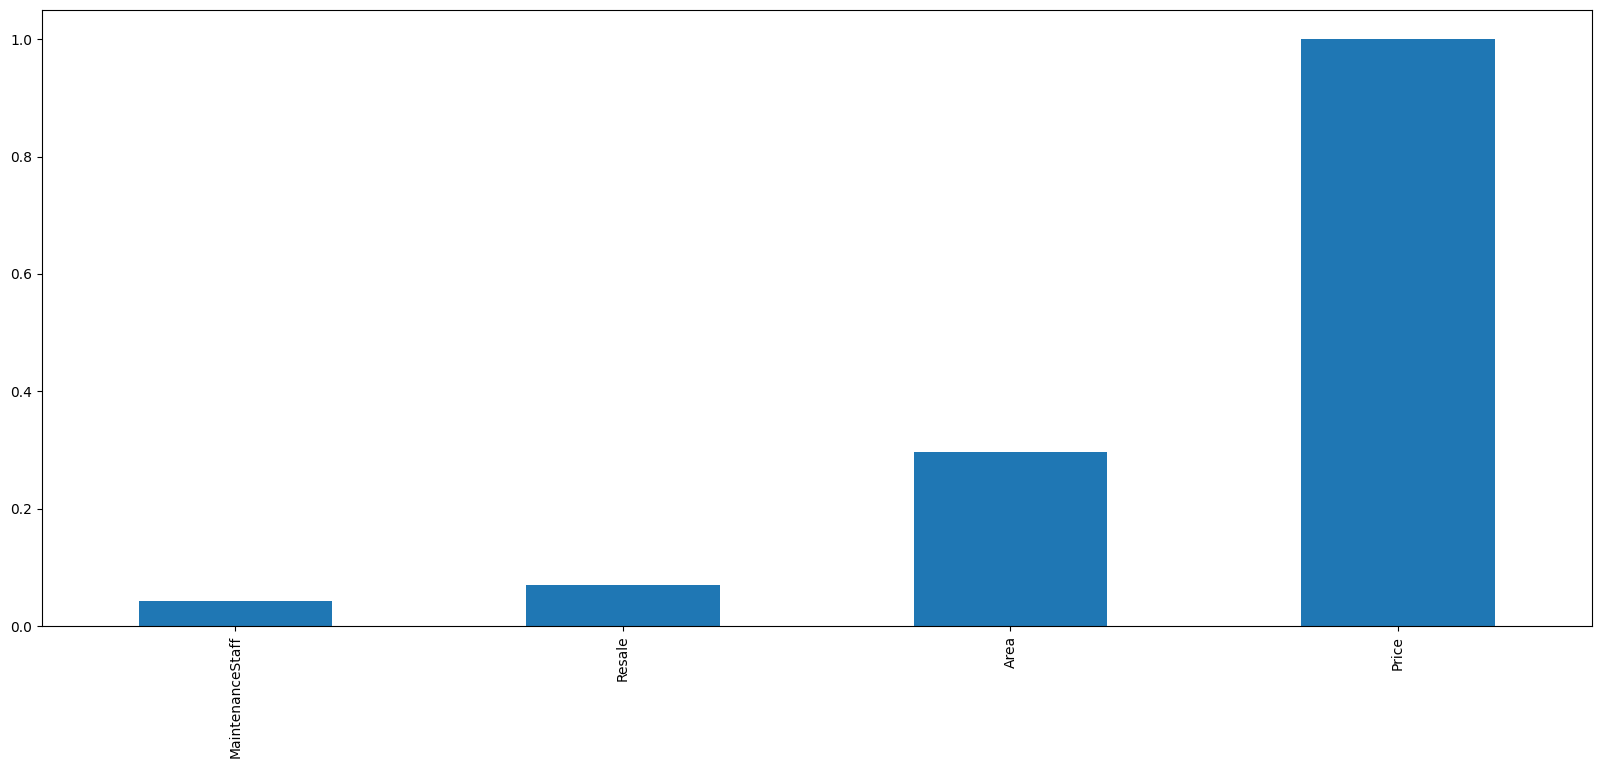

In [4]:
plt.figure(figsize=(20, 8))
data.corr()['Price'].sort_values(ascending=True).plot(kind="bar")

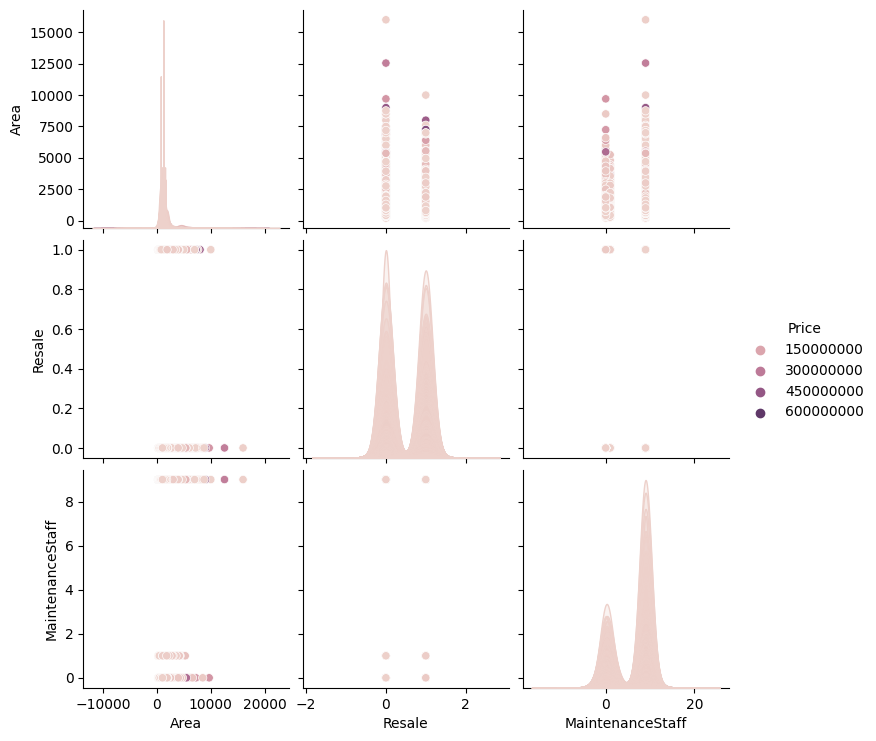

In [5]:
sns.pairplot(data, hue="Price")

#### as we can see the data is not leniar, so we have to use non linear machine learrning algorithms, such as:
1. RandomForestRegressor
2. K nearest neighbour


### Splitting -> Creating Dummy Variable -> Feature Scaling -> Spliting the features into training and testing data

In [6]:
######### splitting the dataset into features and labels ############
features = data.drop('Price', axis=1)
labels = data['Price']
####################################################################

########## Encoding Categorical data #################
features = pd.get_dummies(features)
######################################################

################# Feature Scaling the data ################
scaler = StandardScaler()
features = scaler.fit_transform(features)
############################################################

##################### Spliting the features in training and testing data ##############################
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
#######################################################################################################

In [7]:
forest_model = RandomForestRegressor()
forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [8]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [9]:
base_acccuracy_v1 = evaluate(forest_model, X_test, y_test)

Model Performance
Average Error: 7365273.5684 degrees.
Accuracy = 32.50%.


#### as the above training results in poor results, lets use Randomize search cv to tune the hyperparameter

In [10]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [11]:
# lets create another model
model = RandomForestRegressor()
model_random = RandomizedSearchCV(
    estimator=model,
    param_distributions=random_grid,
    n_iter=10,
    cv=3,
    random_state=42, 
    n_jobs=-1
)

# fit teh random search model
model_random.fit(X_train, y_train)